In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
sys.path.insert(0, '/home/jovyan/mne-python/')
import pickle
import warnings
warnings.filterwarnings("ignore", message="y_pred contains classes not")

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, balanced_accuracy_score

from braindecode.datasets.tuh import TUHAbnormal
from braindecode.preprocessing import create_fixed_length_windows

from decode_tueg import (
    DataScaler, TargetScaler, trial_age_mae, Augmenter, ChannelsSymmetryFB,
    get_datasets, test_name, create_windows, create_final_scores,
    plot_age_gap_hist, plot_violin, accuracy_perumtations, 
    plot_thresh_to_acc, age_gap_diff_permutations,
    plot_learning_curves, save_fig, read_result,
    load_exp, predict_ds, plot_heatmaps
)

In [ ]:
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
sys.path.insert(0, '/home/jovyan/mne-python/')
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_color_codes('deep')
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from sklearn.metrics import mean_absolute_error

from decode_tueg import plot_heatmaps, plot_age_gap_hist, plot_thresh_to_acc, plot_learning_curves

/tmp/ipykernel_23817/3859480325.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
df = pd.read_csv('/home/jovyan/220824_5fcv_huber.csv', index_col=0)

In [ ]:
df

,index,y_pred,y_true,pathological,exp,subset,split,fold
0,0,47.562190,55.0,False,220824144139015381,normal,valid,3
1,1,63.435150,70.0,False,220824144139015381,normal,valid,3
2,2,40.898357,39.0,False,220824144139015381,normal,valid,3
3,3,58.216160,59.0,False,220824144139015381,normal,valid,3
4,4,26.794992,24.0,False,220824144139015381,normal,valid,3
...,...,...,...,...,...,...,...,...
26925,1051,48.591175,38.0,True,220824144055632350,abnormal,train,0
26926,1052,44.417076,85.0,True,220824144055632350,abnormal,train,0
26927,1053,40.556297,31.0,True,220824144055632350,abnormal,train,0
26928,1054,46.593445,40.0,True,220824144055632350,abnormal,train,0


In [ ]:
# only look at valid set
df = df[df.split == 'valid']

In [ ]:
df.shape

(5386, 8)

In [ ]:
mean_absolute_error(df.y_true, df.y_pred)

9.395337378707762

In [ ]:
mean_absolute_error(df[df.pathological].y_true, df[df.pathological].y_pred)

11.63164204531722

In [ ]:
mean_absolute_error(df[~df.pathological].y_true, df[~df.pathological].y_pred)

7.232541631015341

In [ ]:
bin_size = 2
max_age = 100
hist_max_count = 450

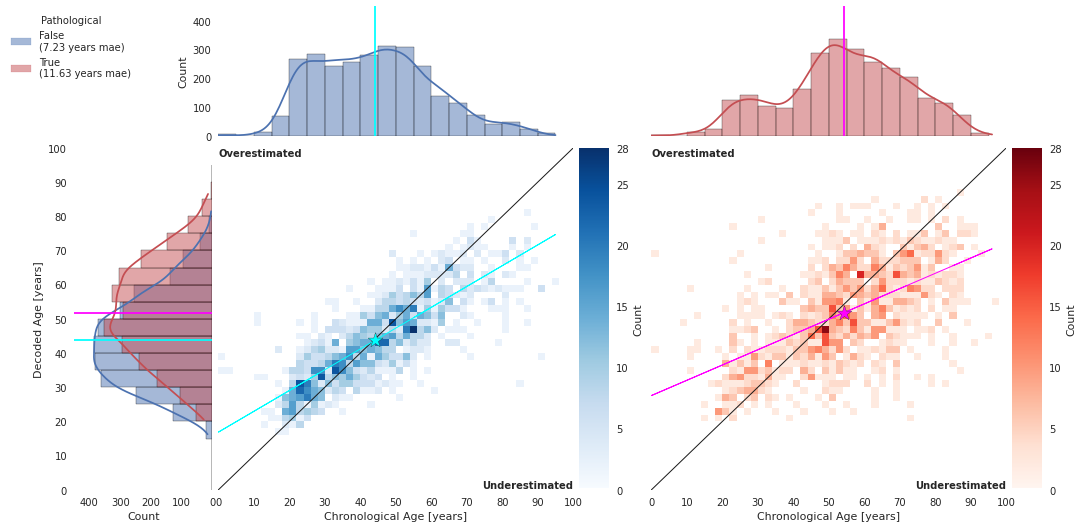

In [14]:
fig = plot_heatmaps(df, bin_size, max_age, hist_max_count)
# fig.savefig('/home/jovyan/new2dhist.png', bbox_inches='tight', dpi=300)

In [45]:
ax = plot_age_gap_hist(df)
ax.get_figure().tight_layout()
ax.set_title('')
# ax.get_figure().savefig('/home/jovyan/age_gap.png', dpi=300, bbox_inches='tight')

NameError: name 'df' is not defined

In [16]:
# plot learning curves

In [25]:
histories = [pd.read_csv(f'/home/jovyan/new_full_runs/{exp}/history.csv', index_col=0) for exp in df.exp.unique()]

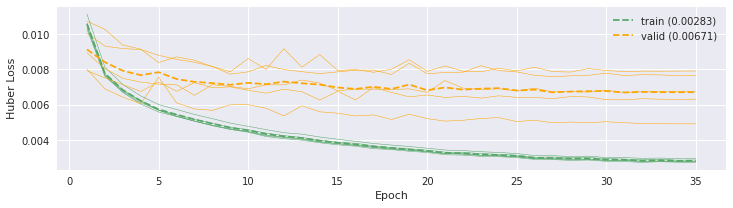

In [27]:
ax = plot_learning_curves(histories, 'Huber Loss')

In [82]:
# plot age gap proxy result

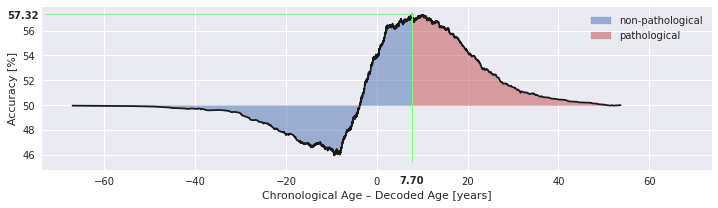

In [83]:
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax = plot_thresh_to_acc(df, ax=ax)
# ax.set_ylim(45,58)
# ax.set_xlim(-70,70)
# fig.savefig('/home/jovyan/proxy.png', bbox_inches='tight', dpi=300)

In [84]:
# plot longitudinal transition decoding results

In [ ]:
bin_size = 2
max_age = 100

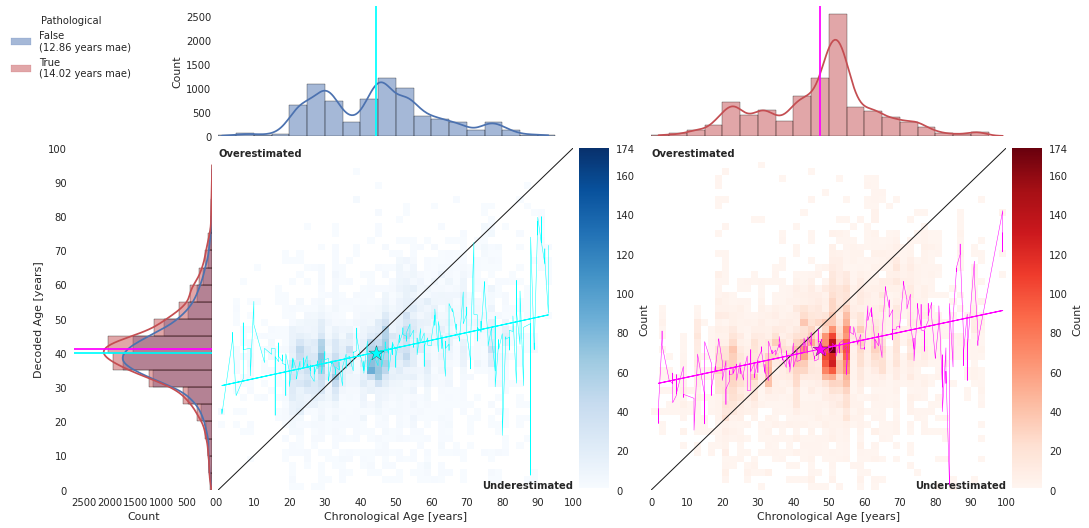

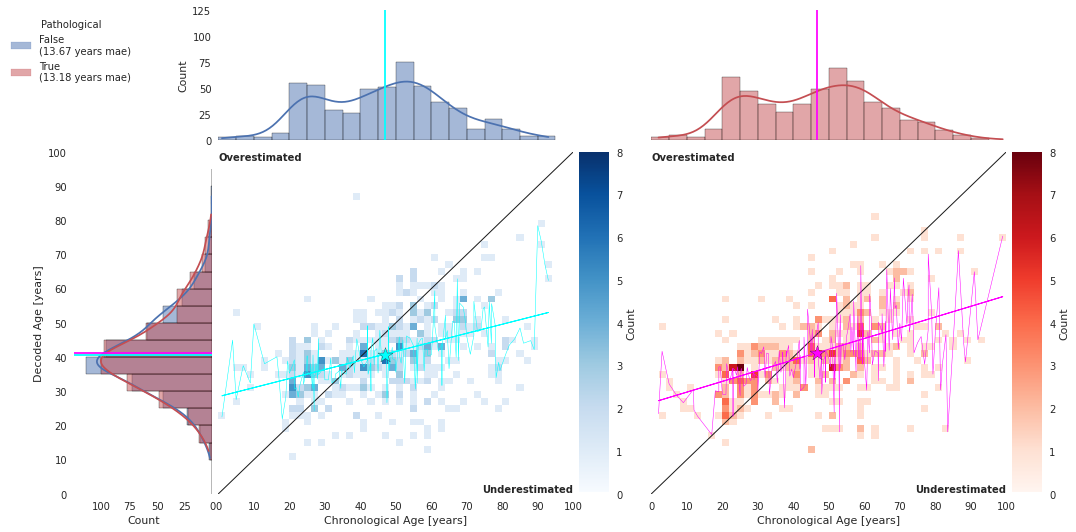

In [ ]:
for subject_wise in [False, True]:
    hist_max_count = 2700 if not subject_wise else 125

    # fdescribe i, longitudinal in enumerate(['transition', 'non_pathological', 'pathological']):
    longitudinal = 'transition'
    df = pd.read_csv(f'/home/jovyan/220824_5fcv_huber_longitudinal_{longitudinal}.csv', index_col=0)
    # --- hack
    with open(f'/home/jovyan/longitudinal/{longitudinal}.pkl', 'rb') as f:
        ds = pickle.load(f)
    df['subject'] = 5*ds.description['subject'].to_list()
    # ---
    if subject_wise:
        df = df.groupby(['subject', 'pathological'], as_index=False).mean()

    ax_arr = plot_heatmaps(df, bin_size, max_age, hist_max_count)
    s = 'recording' if not subject_wise else 'subject'
    # ax_arr.get_figure().savefig(
    #     f'/home/jovyan/longitudinal_{longitudinal}_chronological_vs_predicted_{s}_age.png',
    #     dpi=300, bbox_inches='tight')

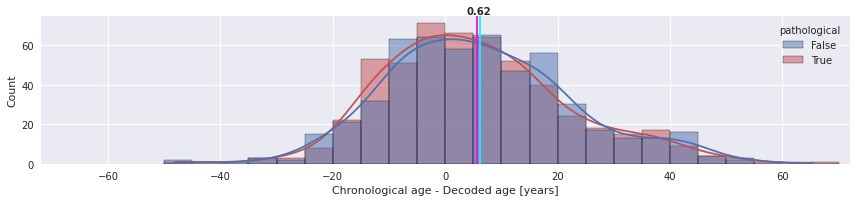

In [103]:
ax = plot_age_gap_hist(df)
ax.get_figure().tight_layout()
ax.set_title('')
s = 'recording' if not subject_wise else 'subject'
# ax.get_figure().savefig(
#     f'/home/jovyan/longitudinal_transition_{s}_age_gap.png', 
#     dpi=300, bbox_inches='tight')

In [3]:
# plot longitudinal pathological and non-pathological decoding results

In [4]:
bin_size = 2
max_age = 100

In [ ]:
for subject_wise in [True]:
    for longitudinal in ['non_pathological', 'pathological']:
        if longitudinal == 'non_pathological':
            hist_max_count = 2200 if not subject_wise else 250
        elif longitudinal == 'pathological':
            hist_max_count = 2200 if not subject_wise else 600

        df = pd.read_csv(f'/home/jovyan/220824_5fcv_huber_longitudinal_{longitudinal}.csv', index_col=0)
        # --- hack
        with open(f'/home/jovyan/longitudinal/{longitudinal}.pkl', 'rb') as f:
            ds = pickle.load(f)
        df['subject'] = 5*ds.description['subject'].to_list()
        # ---
        if subject_wise:
            df = df.groupby(['subject', 'pathological'], as_index=False).mean()

        ax_arr = plot_heatmaps(df, bin_size, max_age, hist_max_count)
        s = 'recording' if not subject_wise else 'subject'
        # ax_arr.get_figure().savefig(
        #     f'/home/jovyan/longitudinal_{longitudinal}_chronological_vs_predicted_{s}_age.png',
        #     dpi=300, bbox_inches='tight')

In [17]:
base_dir = '/home/jovyan/experiments'
# exp = '2022-09-22T15:26:05.896795'
exp = '2022-09-28T22:24:18.385389'

In [2]:
configs = read_result(base_dir, exp, 'config')

NameError: name 'read_result' is not defined

In [1]:
configs.T

NameError: name 'configs' is not defined

In [51]:
scores = read_result(base_dir, exp, 'score')

In [52]:
scores.loc['mae'].groupby('seed').mean()

,train,valid,valid_rest,valid_set_i
seed,,,,
20220429,2.567918,6.810008,11.550411,2.0


In [53]:
scores.loc['mdae'].groupby('seed').mean()

,train,valid,valid_rest,valid_set_i
seed,,,,
20220429,1.532324,5.070547,8.990816,2.0


In [54]:
scores.loc['mdape'].groupby('seed').mean()

,train,valid,valid_rest,valid_set_i
seed,,,,
20220429,0.037691,0.124181,0.174745,2.0


In [55]:
histories = read_result(base_dir, exp, 'history')

<AxesSubplot: xlabel='Epoch', ylabel='L1 Loss'>

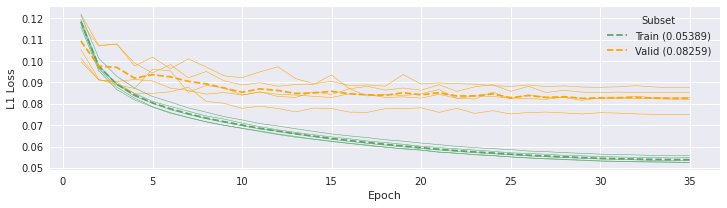

In [57]:
plot_learning_curves([g for n, g in histories.groupby(['seed', 'valid_set_i'])], 'L1 Loss')

In [58]:
preds = read_result(base_dir, exp, 'preds')

In [59]:
preds.shape

(2693, 19)

In [60]:
preds.groupby('subject').mean(numeric_only=True).shape

(2142, 14)

In [61]:
preds.groupby(['subject', 'pathological']).mean(numeric_only=True).shape

(2189, 13)

In [62]:
bin_size = 2
max_age = 100
hist_max_count = 220

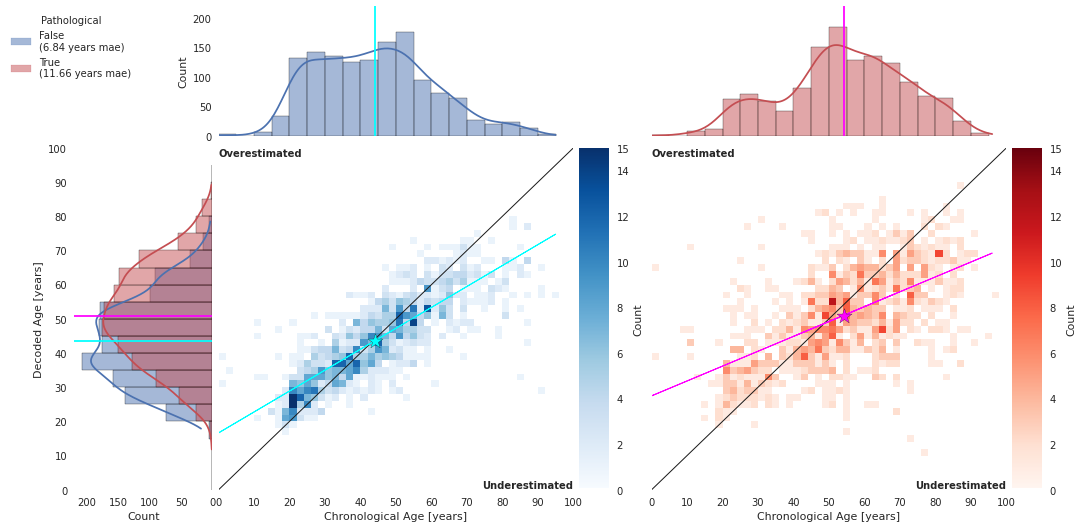

In [63]:
fig = plot_heatmaps(preds, bin_size, max_age, hist_max_count)
# fig.savefig('/home/jovyan/new2dhist.png', bbox_inches='tight', dpi=300)

Text(0.5, 1.0, 'Subject-wise Pathological and Non-Pathological Brain Age Gap')

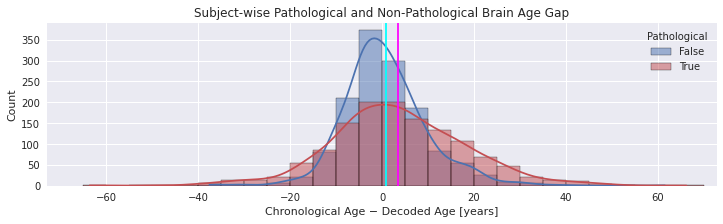

In [64]:
ax = plot_age_gap_hist(preds)
ax.set_title('Subject-wise Pathological and Non-Pathological Brain Age Gap')

In [65]:
n_repetitions = 100000

In [ ]:
# Mittlere Differenz der Brain Age Gaps

Text(0.5, 1.0, 'Mean Subject-wise Difference of Pathological and Non-Pathological Brain Age Gap')

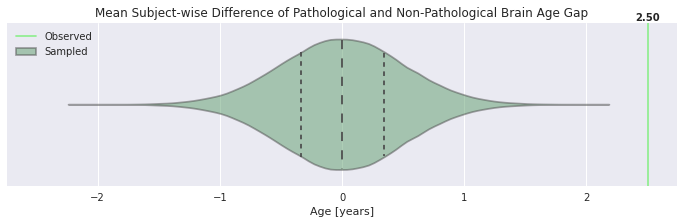

In [26]:
ax = plot_violin(
    *age_gap_diff_permutations(preds, n_repetitions, True), 
    'Age [years]',
)
ax.set_title('Mean Subject-wise Difference of Pathological and Non-Pathological Brain Age Gap')

Text(0.5, 1.0, 'Mean Recording-wise Mean Pathological – Non-Pathological Brain Age Gap')

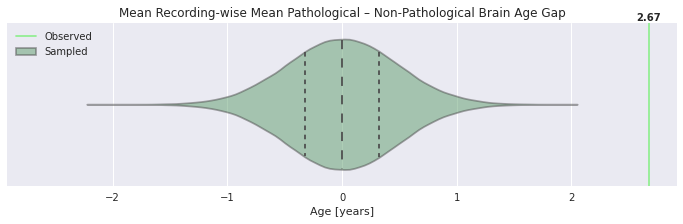

In [27]:
ax = plot_violin(
    *age_gap_diff_permutations(preds, n_repetitions, False),
    'Age [years]',
)
ax.set_title('Mean Recording-wise Mean Pathological – Non-Pathological Brain Age Gap',)

Text(0.5, 1.0, 'Brain Age Gap Pathology Proxy')

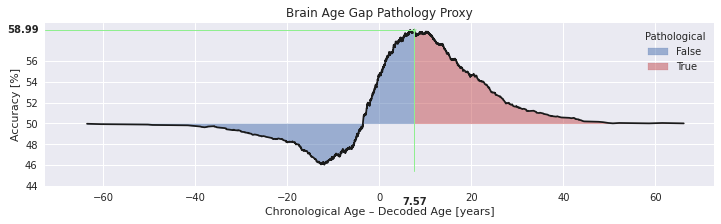

In [31]:
ax = plot_thresh_to_acc(preds)
ax.set_title('Brain Age Gap Pathology Proxy')

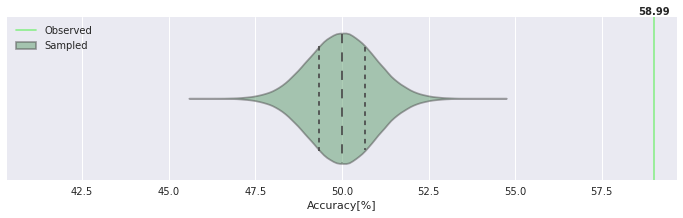

In [32]:
ax = plot_violin(
    *(accuracy_perumtations(preds, n_repetitions)),
    xlabel='Accuracy[%]',
    center_value=50,
)
# ax.get_figure().savefig('/home/jovyan/permutation_test_proxy.png', bbox_inches='tight', dpi=300)

__analyze preds with targets >= 18 years -> improvement?__

In [40]:
preds = preds[preds.y_true >= 18]

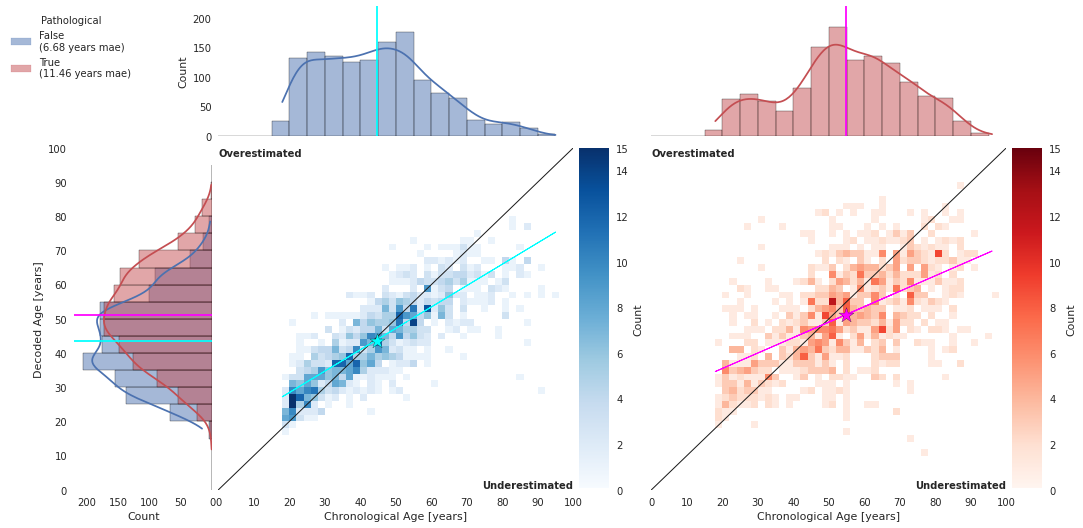

In [41]:
fig = plot_heatmaps(preds, bin_size, max_age, hist_max_count)
# fig.savefig('/home/jovyan/new2dhist.png', bbox_inches='tight', dpi=300)

Text(0.5, 1.0, 'Subject-wise Pathological and Non-Pathological Brain Age Gap')

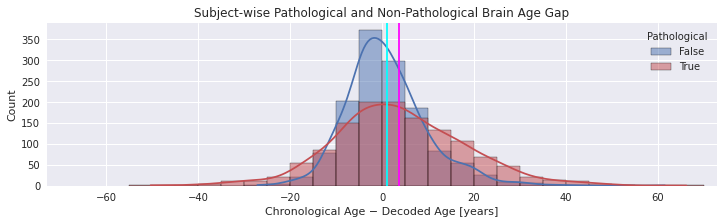

In [42]:
ax = plot_age_gap_hist(preds)
ax.set_title('Subject-wise Pathological and Non-Pathological Brain Age Gap')

Text(0.5, 1.0, 'Mean Subject-wise Difference of Pathological and Non-Pathological Brain Age Gap')

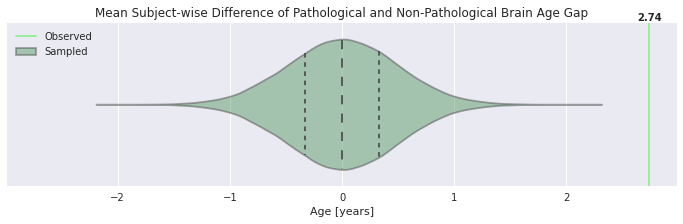

In [43]:
ax = plot_violin(
    *age_gap_diff_permutations(preds, n_repetitions, True), 
    'Age [years]',
)
ax.set_title('Mean Subject-wise Difference of Pathological and Non-Pathological Brain Age Gap')

Text(0.5, 1.0, 'Brain Age Gap Pathology Proxy')

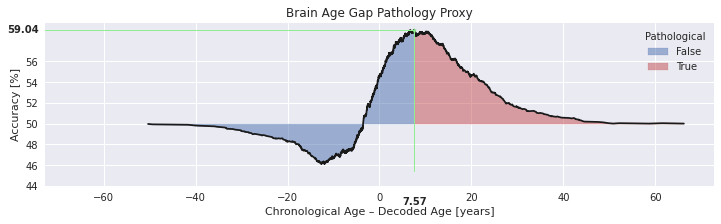

In [44]:
ax = plot_thresh_to_acc(preds)
ax.set_title('Brain Age Gap Pathology Proxy')

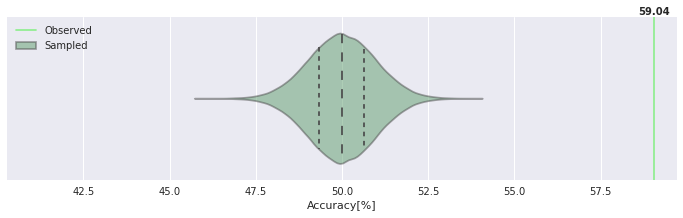

In [46]:
ax = plot_violin(
    *(accuracy_perumtations(preds, n_repetitions)),
    xlabel='Accuracy[%]',
    center_value=50,
)
# ax.get_figure().savefig('/home/jovyan/permutation_test_proxy.png', bbox_inches='tight', dpi=300)